In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

sns.set_style("whitegrid")
np.random.seed(8)
torch.manual_seed(8)

# Generate sine wave

In [74]:
T = 20
L = 1000
N = 100

x = np.zeros((N, L), 'int64')
x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
data = np.sin(x / 1.0 / T).astype('float64')
data

array([[ 0.19866933,  0.24740396,  0.29552021, ..., -0.21381875,
        -0.16472822, -0.11522595],
       [ 0.94898462,  0.96355819,  0.97572336, ...,  0.74097261,
         0.77360936,  0.80431249],
       [ 0.47203054,  0.42737988,  0.38166099, ...,  0.78770523,
         0.75593102,  0.72226737],
       ...,
       [-0.51550137, -0.55768372, -0.59847214, ..., -0.12577619,
        -0.17520127, -0.22418844],
       [ 0.8134155 ,  0.84147098,  0.86742323, ...,  0.50942594,
         0.55179709,  0.59278903],
       [-0.05837414, -0.10819513, -0.15774569, ...,  0.34953534,
         0.30227187,  0.25425287]])

In [75]:
train_input = torch.from_numpy(data[3:, :-1])
train_target = torch.from_numpy(data[3:, 1:])
val_input = torch.from_numpy(data[:3, :-1])
val_target = torch.from_numpy(data[:3, 1:])

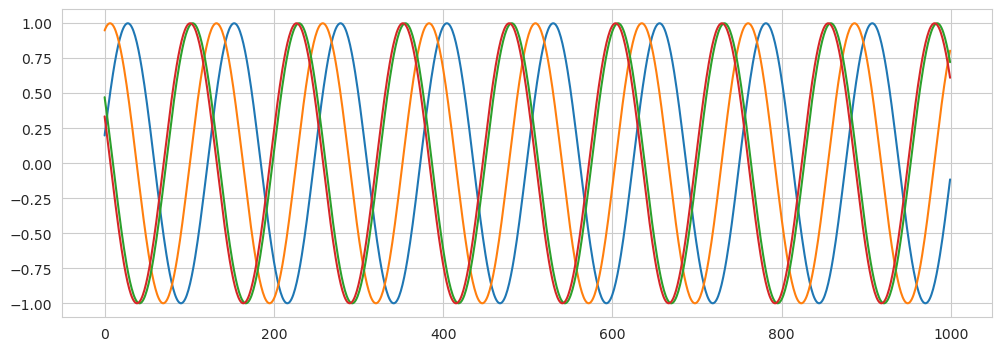

In [76]:
plt.figure(figsize=(12, 4))
for wave in data[:4, :].tolist():
    plt.plot(range(len(wave)), wave)

plt.show()

In [77]:
data.shape

(100, 1000)

Data has 100 waves, each wave consists of 1000 points.

In [78]:
train_input = torch.from_numpy(data[3:, :-1])
train_target = torch.from_numpy(data[3:, 1:])
val_input = torch.from_numpy(data[:3, :-1])
val_target = torch.from_numpy(data[:3, 1:])

We use 97 waves as training set and 3 waves as test set.

In [79]:
train_input.shape, train_target.shape

(torch.Size([97, 999]), torch.Size([97, 999]))

In [80]:
val_input.shape, val_target.shape

(torch.Size([3, 999]), torch.Size([3, 999]))

In [81]:
train_input

tensor([[ 0.3350,  0.2875,  0.2392,  ...,  0.7223,  0.6868,  0.6496],
        [ 0.1494,  0.1987,  0.2474,  ..., -0.3103, -0.2624, -0.2138],
        [ 0.9320,  0.9490,  0.9636,  ...,  0.6702,  0.7065,  0.7410],
        ...,
        [-0.5155, -0.5577, -0.5985,  ..., -0.0760, -0.1258, -0.1752],
        [ 0.8134,  0.8415,  0.8674,  ...,  0.4658,  0.5094,  0.5518],
        [-0.0584, -0.1082, -0.1577,  ...,  0.3959,  0.3495,  0.3023]],
       dtype=torch.float64)

In [82]:
train_target

tensor([[ 0.2875,  0.2392,  0.1904,  ...,  0.6868,  0.6496,  0.6108],
        [ 0.1987,  0.2474,  0.2955,  ..., -0.2624, -0.2138, -0.1647],
        [ 0.9490,  0.9636,  0.9757,  ...,  0.7065,  0.7410,  0.7736],
        ...,
        [-0.5577, -0.5985, -0.6378,  ..., -0.1258, -0.1752, -0.2242],
        [ 0.8415,  0.8674,  0.8912,  ...,  0.5094,  0.5518,  0.5928],
        [-0.1082, -0.1577, -0.2069,  ...,  0.3495,  0.3023,  0.2543]],
       dtype=torch.float64)

The input and target have the exact same shape, but the target is just the input but shifted 1 step to the left, i.e. the corresponding target of an input is just its next value.

![image](attachment/Screenshot_20240719_212944.png)

# Model Architecture

In [83]:
# specify dtype float64 because input is in this dtype
# and pytorch defaults to float32
DTYPE = torch.float64


class LSTM(nn.Module):
    
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm1 = nn.LSTMCell(input_size=1, hidden_size=64, dtype=DTYPE)
        self.lstm2 = nn.LSTMCell(input_size=64, hidden_size=64, dtype=DTYPE)
        self.linear = nn.Linear(in_features=64, out_features=1, dtype=DTYPE)

    def forward(self, input, future=0):
        outputs = []
        h1 = torch.zeros(input.shape[0], 64, dtype=DTYPE)
        c1 = torch.zeros(input.shape[0], 64, dtype=DTYPE)
        h2 = torch.zeros(input.shape[0], 64, dtype=DTYPE)
        c2 = torch.zeros(input.shape[0], 64, dtype=DTYPE)

        # iterate through each value of all samples together
        for input_t in input.split(1, dim=1):
            input_t = input_t.type(DTYPE)
            h1, c1 = self.lstm1(input_t, (h1, c1))
            h2, c2 = self.lstm2(h1, (h2, c2))
            output = self.linear(h2)
            outputs += [output]

        for i in range(future):
            h1, c1 = self.lstm1(output, (h1, c1))
            h2, c2 = self.lstm2(h1, (h2, c2))
            output = self.linear(h2)
            outputs += [output]
            
        outputs = torch.cat(outputs, dim=1)
        return outputs


lstm = LSTM()
lstm

LSTM(
  (lstm1): LSTMCell(1, 64)
  (lstm2): LSTMCell(64, 64)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

# Training